<a href="https://colab.research.google.com/github/vicentegilso/clasificaciondeimagenes/blob/main/How_to_use_a_Pretrained_Deep_Learning_Object_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Use a Pretrained Model to Identify Objects

In this notebook we will learn how to use a model to identify objects.

We say that the model is pretrained because normally the model per se does not know how to identify anything.

Once we feed the model with annotated samples it can learn how to identify objects.

We will use a model that has been already trained and somebody shared its **parameters** so we can load these parameters with the model and just use it (yes, that is what we have done in the previous notebook with `dlib` but without fancy words).

## Using PyTorch and Torchvision

We will use PyTorch as our Deep Learning framework. 

Within PyTorch there are multiple extra projects, one of them is Torchvision, and this one provides trained Object Detection Models.

<p>
<br>
<img src="https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png" alt="drawing" width="300"/>

### What is PyTorch?
(*from PyTorch website*)

It’s a Python-based scientific computing package targeted at two sets of audiences:

* A replacement for NumPy to use the power of GPUs
* a deep learning research platform that provides maximum flexibility and speed

For us, main benefits:
* We can use trained models
* We can use models on GPU

### Make sure yout environment runs on GPU

First go to:
`Runtime > Change runtime type`

<!-- ![alt text](https://storage.googleapis.com/animated_content_tutorial/gpu_runtime_1.png) -->

Then select GPU. 

If you where using CPU your enviroment will be restarted.
<!-- 
![alt text](https://storage.googleapis.com/animated_content_tutorial/gpu_runtime_2.png) -->

## Tensor? What Tensor?

(*from PyTorch webpage*)

A PyTorch Tensor is basically the same as a `numpy.array`: 

it does not know anything about deep learning or computational graphs or gradients, and is just a generic n-dimensional array to be used for arbitrary numeric computation.

In [ ]:
import torch
import torchvision
from PIL import Image, ImageDraw

# this will tell pytorch that we want to use the GPU
device = torch.device('cuda')

In [ ]:
! pip install gpustat

     |████████████████████████████████| 81kB 6.0MB/s 
  Created wheel for gpustat: filename=gpustat-0.6.0-cp37-none-any.whl size=12621 sha256=29b412784484198310cfa4373118d9e6dbe91e7b709a7dcc7a09324eee7dfa92
  Stored in directory: /root/.cache/pip/wheels/48/b4/d5/fb5b7f1d040f2ff20687e3bad6867d63155dbde5a7c10f4293
Successfully built gpustat


In [ ]:
! gpustat

2ef19294d10b         Sat Jul  3 04:45:28 2021  460.32.03
[0] Tesla T4         | 42'C,   0 % |     0 / 15109 MB |


In [ ]:
# we will use this later, but these are the categories
# that the model knows to identify
# more formaly this is the domain of the model

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [ ]:
# old friends :-)
from PIL import ImageFont
from PIL import ImageDraw 
import matplotlib.pyplot as plt

def my_draw_rectangle(draw, coordinates, color, width=1):
    for i in range(width):
        rect_start = (coordinates[0][0] - i, coordinates[0][1] - i)
        rect_end = (coordinates[1][0] + i, coordinates[1][1] + i)
        draw.rectangle((rect_start, rect_end), outline = color)
        
def draw_rectangle(img, boundingBox):
    draw = ImageDraw.Draw(img)
    np_img = np.array(img)
    x1, y1 = boundingBox[0], boundingBox[1]
    x2, y2 = boundingBox[2], boundingBox[3]
    my_draw_rectangle(
        draw, 
        ((x1,y1), (x2, y2)), 
        "green", 
        int((np_img.shape[0])/100)
      )
    return img

def draw_faces(img, detected_faces):
    detected_faces = faces2dic(detected_faces)
    for face in detected_faces:
        bounding_box = [face["x1"], face["y1"], 
                      face["x2"], face["y2"]]
        img = draw_rectangle(img, bounding_box)
    return img

# we add this function to add text around the bbox
def add_text(img, bbox, label):
  '''
    This function takes an image and a bounding box and adds a label to visualize
    the object detected
  '''
  draw = ImageDraw.Draw(img)
  # font = ImageFont.truetype(<font-file>, <font-size>)
  # font = ImageFont.truetype(font=ImageFont.load_default().font,size=16)
  font = ImageFont.load_default()
  x, y = bbox[0], bbox[1]
  w, h = font.getsize(label)
  y = y - h
  draw.rectangle((x - h*0.20, y, x + w, y + h), fill='green')
  draw.text((x, y), label, (255,255,255), font=font)
  return img

def draw_objects(img, object_bbox, object_labels, object_porbs, threshold=0.5, show_probs=False):
  '''
    This function takes:
      - an image
      - a list of bounding boxes
      - a list of labels for each object_bbox
      - a list of probabilities correspondig to each label probability
        of the detected objects
      - a threshold to filter the object to show
      - flag to show probabilties in labels
  '''
  for bbox, label, prob in zip(object_bbox, object_labels, object_porbs):
    if prob > threshold:
      img = draw_rectangle(img, bbox)
      if show_probs:
        label = '{} ({:.2f}%)'.format(label, prob*100)
      img = add_text(img, bbox, label)
  display(img)

def faces2dic(faces):
    return [{"x1":f[0], "y1":f[1], "x2":f[2], "y2":f[3]} for f in faces]

## FasterRCNN

I will not stop here and see the details of this model. 

You can check this great [blog post](https://lilianweng.github.io/lil-log/2017/12/31/object-recognition-for-dummies-part-3.html) to have a more detailed vision of what the model does.


Instead I will show how to use it, and basically we will have to feed in an image and visualize the bounding boxes that it will output.

Take into account that the model:
1. Detects the object in the image
2. Classifies the object in the image (it also outputs the probability of the object being an specific class)




In [ ]:
# in order to load the model we just have to instatiate it
# and specify that it is pretrained, it will download the weights 
# and instantiate the model ready to run and detect objects
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
# for inference you can use cpu
# but hey, GPU for free ¯\_(ツ)_/¯
# model.to(torch.device('cpu'))
model.eval()

# test with random images
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]

predictions = model(x)

Consider few things:
* We are passing a list of images (normaly models expect batches of images)
* Now depth is in first place `(3, 300, 400)`. We have seen that it normally comes at last position
* `torch.rand` returns a random number in the range $[0, 1]$. We have seen that it normaly is in the range $[0, 255]$

Taking this into consideration, let's use it.

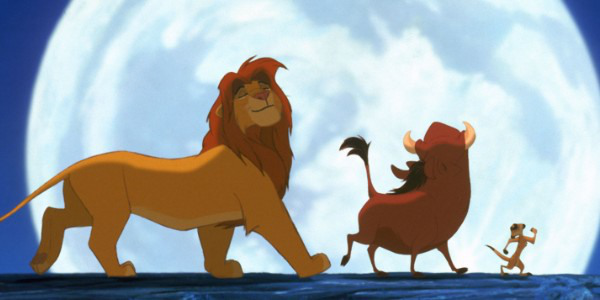

In [ ]:
# load the simba, pumba and timon image
from io import BytesIO
from PIL import Image
import numpy as np
import requests

# I will use an url so this can work anywhere
url_to_img = 'https://img.cinemablend.com/filter:scale/quill/6/7/8/7/3/9/6787393f465857de4093169984c76a7e020749b4.jpg'
# download the image
response = requests.get(url_to_img)
# open it
img = Image.open(BytesIO(response.content))
display(img)

Now, we have an image. Let's run it!

In [ ]:
# convert the image to tensor
image_tensor = torch.tensor(np.array(img), dtype=torch.float32)

# we have 2 problems
# 1. the shape the model expexts is (depth, height, width) and we have (height, width, depth)
# 2. the model expects a batch, we only have an image
print('oooops: {}'.format(image_tensor.shape))
image_tensor = image_tensor.permute(2,0,1).unsqueeze(0)
print('ready to go: {}'.format(image_tensor.shape))

# one last problem, the model expect pixels to me normalized around 0 and 1
print('wait a moment!! max: {} min: {}'.format(image_tensor.max(), image_tensor.min()))
image_tensor = image_tensor/255
print('go go go!! max: {} min: {}'.format(image_tensor.max(), image_tensor.min()))

oooops: torch.Size([300, 600, 3])
ready to go: torch.Size([1, 3, 300, 600])
wait a moment!! max: 255.0 min: 0.0
go go go!! max: 1.0 min: 0.0


Now we have our image prepared as a Tensor ready to be processed.

In [ ]:
output = model(image_tensor)

Let's take a look at what we have


In [ ]:
print('shape of the output {}'.format(len(output)))
print('contents of the output {}'.format(output[0].keys()))

shape of the output 1
contents of the output dict_keys(['boxes', 'labels', 'scores'])


To manipulate it we'll cast to `numpy.array`

In [ ]:
# convert bounding boxes to a list of coordinates
bboxes = output[0]['boxes'].detach().numpy().tolist()
# convert label index to strings
labels = [COCO_INSTANCE_CATEGORY_NAMES[l] for l in output[0]['labels'].detach().numpy().tolist()]
# convert scores to list
probs = output[0]['scores'].detach().numpy().tolist()

In [ ]:
len(bboxes)

24

In [ ]:
len(probs)

24

In [ ]:
list(zip(probs, labels))

[(0.9235726594924927, 'person'),
 (0.6473875641822815, 'horse'),
 (0.5511822700500488, 'elephant'),
 (0.42847657203674316, 'umbrella'),
 (0.34773609042167664, 'kite'),
 (0.25086426734924316, 'person'),
 (0.24714528024196625, 'umbrella'),
 (0.21952006220817566, 'umbrella'),
 (0.20338469743728638, 'elephant'),
 (0.1940680593252182, 'bird'),
 (0.18486852943897247, 'person'),
 (0.17863261699676514, 'bird'),
 (0.1613088697195053, 'bird'),
 (0.15269728004932404, 'kite'),
 (0.14969274401664734, 'cow'),
 (0.14821173250675201, 'kite'),
 (0.12912695109844208, 'bird'),
 (0.07937207072973251, 'elephant'),
 (0.07753559947013855, 'person'),
 (0.06578251719474792, 'chair'),
 (0.06538674235343933, 'umbrella'),
 (0.06518207490444183, 'bird'),
 (0.060609716922044754, 'sheep'),
 (0.052589330822229385, 'dog')]

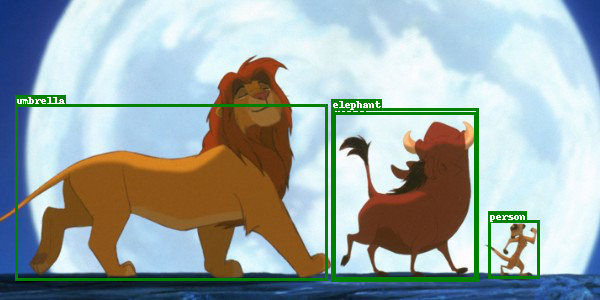

In [ ]:
  draw_objects(img, bboxes, labels, probs, threshold=0.4)

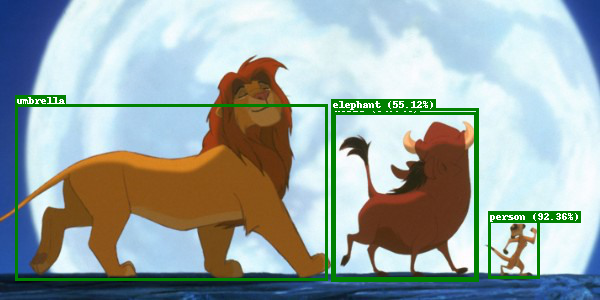

In [ ]:
  draw_objects(img, bboxes, labels, probs, threshold=0.5, show_probs=True)

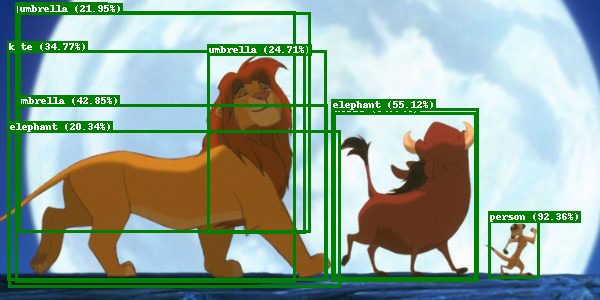

In [ ]:
  draw_objects(img, bboxes, labels, probs, threshold=0.2, show_probs=True)

## Conclusions

* We have seen how to instantiate a pretrained model using PyTorch
* We see that it performs well in Animated Content...
* **Really?**
* Well, it fails, but recall that it has been trained in a diferent domain, so let's be fair, it does a good job
* What do you think? Do you think, that training in the correct domain it can detect object in animated content?